## Session 3

### Assignment 1: Write a program to create a panorama image step-by-step

The process is: SIFT points $\rightarrow$ FLANN matcher $\rightarrow$ RANSAC $\rightarrow$ H matrix $\rightarrow$ wrap

In [ ]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

def load_images(image_paths):
    """
    Load images from the provided file paths
    """
    images = []
    for path in image_paths:
        if not os.path.exists(path):
            print(f"Warning: Image file {path} does not exist.")
            continue
        img = cv2.imread(path)
        if img is None:
            print(f"Warning: Could not load image {path}.")
            continue
        images.append(img)
    
    return images

def detect_and_match_features(img1, img2):
    """
    Detect SIFT features and match them between two images using FLANN
    """
    # Initialize SIFT detector
    sift = cv2.SIFT_create()
    
    # Find keypoints and descriptors with SIFT
    kp1, des1 = sift.detectAndCompute(img1, None)
    kp2, des2 = sift.detectAndCompute(img2, None)
    
    # FLANN parameters
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=50)
    
    # FLANN matcher
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    
    # Find the 2 nearest neighbors for each descriptor
    matches = flann.knnMatch(des1, des2, k=2)
    
    # Apply Lowe's ratio test to filter good matches
    good_matches = []
    for m, n in matches:
        if m.distance < 0.7 * n.distance:  # Lowe's ratio test
            good_matches.append(m)
    
    return kp1, kp2, good_matches

def estimate_homography(kp1, kp2, good_matches, min_match_count=4):
    """
    Estimate homography matrix using RANSAC
    """
    if len(good_matches) < min_match_count:
        print(f"Not enough matches found: {len(good_matches)} < {min_match_count}")
        return None
    
    # Extract locations of matched keypoints
    src_pts = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    dst_pts = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    
    # Find homography matrix using RANSAC
    H, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
    
    # Count inliers (points that fit the homography model)
    inliers = np.sum(mask)
    print(f"Homography estimation - Inliers: {inliers}/{len(good_matches)}")
    
    return H

def warp_and_stitch(img1, img2, H):
    """
    Warp img1 using homography H and stitch with img2
    """
    # Get dimensions
    h1, w1 = img1.shape[:2]
    h2, w2 = img2.shape[:2]
    
    # Calculate the dimensions of the canvas based on the homography
    corners1 = np.float32([[0, 0], [0, h1], [w1, h1], [w1, 0]]).reshape(-1, 1, 2)
    corners2_transformed = cv2.perspectiveTransform(corners1, H)
    
    [xmin, ymin] = np.int32(corners2_transformed.min(axis=0).ravel() - 0.5)
    [xmax, ymax] = np.int32(corners2_transformed.max(axis=0).ravel() + 0.5)
    
    # Offset to ensure all points are positive
    t_x = -min(0, xmin)
    t_y = -min(0, ymin)
    
    # Translation matrix
    translation_matrix = np.array([
        [1, 0, t_x],
        [0, 1, t_y],
        [0, 0, 1]
    ])
    
    # Apply translation to the homography matrix
    H_translation = translation_matrix.dot(H)
    
    # Determine canvas size
    output_size = (max(xmax + t_x, w2 + t_x), max(ymax + t_y, h2 + t_y))
    
    # Warp the first image (img1) onto the canvas
    warped_img = cv2.warpPerspective(img1, H_translation, output_size)
    
    # Create a new canvas for the second image
    img2_canvas = np.zeros_like(warped_img)
    img2_canvas[t_y:t_y+h2, t_x:t_x+w2] = img2
    
    # Create masks for non-black pixels in each image
    warped_mask = (cv2.cvtColor(warped_img, cv2.COLOR_BGR2GRAY) > 0)
    img2_mask = (cv2.cvtColor(img2_canvas, cv2.COLOR_BGR2GRAY) > 0)
    
    # Find overlapping regions
    overlap = warped_mask & img2_mask
    
    # Apply simple blending
    result = warped_img.copy()
    
    # In non-overlapping regions, keep the original pixels
    # In overlapping regions, take the average of both images
    for y in range(output_size[1]):
        for x in range(output_size[0]):
            if overlap[y, x]:
                # Average the pixels in overlapping regions
                result[y, x] = (warped_img[y, x].astype(np.float32) + 
                              img2_canvas[y, x].astype(np.float32)) / 2
            elif img2_mask[y, x]:
                # Use img2's pixel where there's no content in warped_img
                result[y, x] = img2_canvas[y, x]
    
    return result.astype(np.uint8)


def crop_black_borders(img):
    """
    Advanced cropping of black borders from stitched panorama.
    Uses contour detection and minimum area rectangle to remove all black regions.
    """
    # Create a threshold to identify non-black pixels
    # Use threshold=10 instead of 1 to account for very dark pixels and compression artifacts
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    thresh = cv2.threshold(gray, 10, 255, cv2.THRESH_BINARY)[1]
    
    # Apply morphological operations to clean up the mask
    kernel = np.ones((3, 3), np.uint8)
    thresh = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)
    
    # Find contours - should get the main content area
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    if not contours:
        print("Warning: No content area found. Returning original image.")
        return img
    
    # Find the largest contour (should be our panorama content)
    largest_contour = max(contours, key=cv2.contourArea)
    
    # OPTION 1: Use simple bounding rectangle (fastest but may include some black areas)
    x, y, w, h = cv2.boundingRect(largest_contour)
    cropped = img[y:y+h, x:x+w]
    
    # OPTION 2: For more precise cropping, use rotated minimum area rectangle
    # Find minimum area rectangle that fits the content
    rect = cv2.minAreaRect(largest_contour)
    box = np.int32(cv2.boxPoints(rect))
    
    # Get the corners of the rectangle
    (topy, topx) = (np.min(box[:,1]), np.min(box[:,0]))
    (boty, botx) = (np.max(box[:,1]), np.max(box[:,0]))
    
    # Ensure we don't go out of bounds
    topx = max(0, topx)
    topy = max(0, topy)
    botx = min(img.shape[1], botx)
    boty = min(img.shape[0], boty)
    
    # Crop using the rectangle
    precise_crop = img[topy:boty, topx:botx]
    
    # Create inverse mask to find black areas inside the cropped region
    inv_thresh = 255 - thresh[topy:boty, topx:botx]
    
    # Find contours in the inverse mask (these are the black regions)
    inner_contours, _ = cv2.findContours(inv_thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Initialize boundaries
    x0, y0 = 0, 0
    x1, y1 = precise_crop.shape[1], precise_crop.shape[0]
    
    # Analyze contours at the borders to further refine the crop
    for c in inner_contours:
        (x, y, w, h) = cv2.boundingRect(c)
        
        # Left border black region
        if (x == 0) and (h > w):
            x0 = max(x0, w)
        # Right border black region
        elif ((x + w) == precise_crop.shape[1]) and (h > w):
            x1 = min(x1, x)
        # Top border black region
        elif (y == 0) and (w > h):
            y0 = max(y0, h)
        # Bottom border black region
        elif ((y + h) == precise_crop.shape[0]) and (w > h):
            y1 = min(y1, y)
    
    # Final crop removing any border black regions
    final_crop = precise_crop[y0:y1, x0:x1]
    
    print(f"Original dimensions: {img.shape[:2]}")
    print(f"Cropped dimensions: {final_crop.shape[:2]}")
    
    return final_crop

def stitch_images(image_paths, output_path, display=True):
    """
    Main function to stitch multiple images into a panorama
    """
    # Load all images
    images = load_images(image_paths)
    
    if len(images) < 2:
        print("Need at least 2 images to create a panorama.")
        return None
    
    # Start with the first image as the base panorama
    panorama = images[0]
    
    # Process image pairs sequentially
    for i in range(1, len(images)):
        print(f"Stitching image {i+1}/{len(images)}...")
        
        # Current image to stitch with the panorama
        img_current = images[i]
        
        # Convert images to grayscale for feature detection
        img1_gray = cv2.cvtColor(panorama, cv2.COLOR_BGR2GRAY)
        img2_gray = cv2.cvtColor(img_current, cv2.COLOR_BGR2GRAY)
        
        # Detect and match features
        kp1, kp2, good_matches = detect_and_match_features(img1_gray, img2_gray)
        
        if len(good_matches) < 4:
            print(f"Warning: Not enough good matches found between panorama and image {i+1}. Skipping...")
            continue
        
        # Estimate homography
        H = estimate_homography(kp1, kp2, good_matches)
        
        if H is None:
            print(f"Warning: Could not estimate homography for image {i+1}. Skipping...")
            continue
        
        # Warp and stitch
        panorama = warp_and_stitch(panorama, img_current, H)

    # Save the uncropped panorama (with black regions)
    # Create uncropped output path by adding "_uncropped" before the file extension
    base_name, ext = os.path.splitext(output_path)
    uncropped_output_path = f"{base_name}_uncropped{ext}"
    cv2.imwrite(uncropped_output_path, panorama)
    print(f"Uncropped panorama saved to {uncropped_output_path}")
    
    # Display the uncropped panorama if requested
    if display:
        plt.figure(figsize=(15, 10))
        plt.imshow(cv2.cvtColor(panorama, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.title("Panorama (Uncropped)")
        plt.show()
    
    # Crop black borders for the final version
    cropped_panorama = crop_black_borders(panorama)
    
    # Save the cropped panorama
    cv2.imwrite(output_path, cropped_panorama)
    print(f"Cropped panorama saved to {output_path}")
    
    # Display the cropped panorama if requested
    if display:
        plt.figure(figsize=(15, 10))
        plt.imshow(cv2.cvtColor(cropped_panorama, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.title("Panorama (Cropped)")
        plt.show()
    
    return cropped_panorama

# Example usage
if __name__ == "__main__":
    # Replace with actual image paths
    image_paths = ["./resources/first.png", "./resources/second.png"]
    output_path = "./resources/panorama_output_1.jpg"
    
    stitch_images(image_paths, output_path)

### Assignment 2: Using cv2.createSticher function or cv2.Sticher_create function

Loading 4 images...
Stitching 4 images...
Stitching successful
Uncropped panorama saved to ./resources/panorama_result_uncropped.jpg


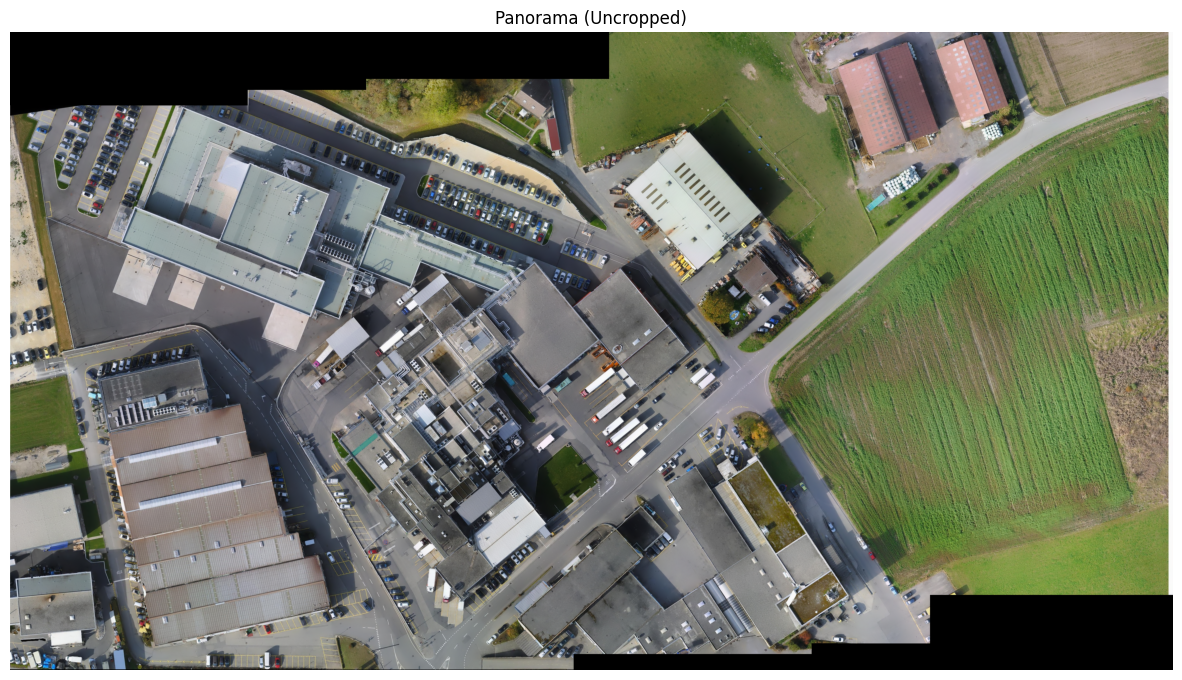

Original dimensions: (3081, 5610)
Cropped dimensions: (2186, 5608)
Cropped panorama saved to ./resources/panorama_result.jpg


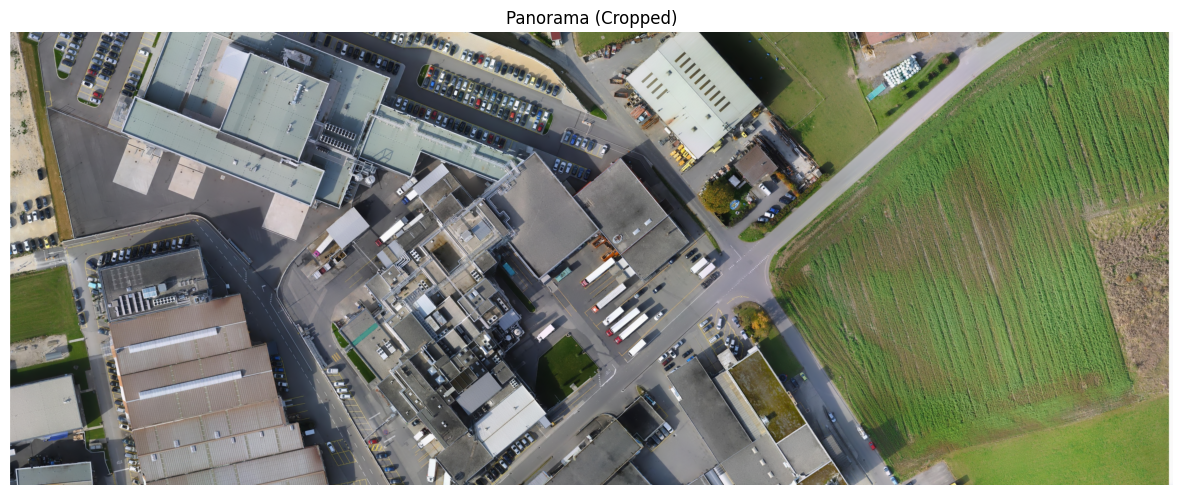

In [23]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

def load_images(image_paths):
    """
    Load images from the specified file paths
    
    Args:
        image_paths (list): List of file paths to input images
        
    Returns:
        list: List of loaded images as NumPy arrays
    """
    images = []
    for path in image_paths:
        if not os.path.exists(path):
            print(f"Warning: Image {path} does not exist. Skipping.")
            continue
        
        img = cv2.imread(path)
        if img is None:
            print(f"Warning: Could not read image {path}. Skipping.")
            continue
            
        images.append(img)
    
    return images

def create_stitcher(try_use_gpu=False):
    """
    Create a cv2.Stitcher object with version compatibility
    
    Args:
        try_use_gpu (bool): Whether to try using GPU for stitching
        
    Returns:
        cv2.Stitcher: A Stitcher object
    """
    # Check OpenCV version for proper Stitcher creation
    return cv2.Stitcher_create(int(try_use_gpu))

def get_status_message(status):
    """
    Convert stitcher status code to human-readable message
    """
    # Handle different OpenCV versions
    if hasattr(cv2, 'Stitcher_OK'):
        status_dict = {
            cv2.Stitcher_OK: "Stitching successful",
            cv2.Stitcher_ERR_NEED_MORE_IMGS: "Error: Need more images",
            cv2.Stitcher_ERR_HOMOGRAPHY_EST_FAIL: "Error: Homography estimation failed",
            cv2.Stitcher_ERR_CAMERA_PARAMS_ADJUST_FAIL: "Error: Camera parameter adjustment failed"
        }
    else:
        status_dict = {
            cv2.Stitcher.OK: "Stitching successful",
            cv2.Stitcher.ERR_NEED_MORE_IMGS: "Error: Need more images",
            cv2.Stitcher.ERR_HOMOGRAPHY_EST_FAIL: "Error: Homography estimation failed",
            cv2.Stitcher.ERR_CAMERA_PARAMS_ADJUST_FAIL: "Error: Camera parameter adjustment failed"
        }
    
    return status_dict.get(status, f"Unknown error: Status code {status}")

def create_panorama(image_paths, output_path='panorama_output.jpg', try_use_gpu=False, display=True):
    """
    Create a panoramic image by stitching multiple images together
    
    Args:
        image_paths (list): List of paths to input images
        output_path (str): Path where output panorama will be saved
        try_use_gpu (bool): Whether to try using GPU for stitching
        display (bool): Whether to display the result
        
    Returns:
        numpy.ndarray: The panoramic image if successful, None otherwise
    """
    # Load input images
    print(f"Loading {len(image_paths)} images...")
    images = load_images(image_paths)
    
    if len(images) < 2:
        print("Error: At least two valid images are required for stitching.")
        return None
    
    print(f"Stitching {len(images)} images...")
    
    # Create a stitcher
    stitcher = create_stitcher(try_use_gpu)
    
    # Perform stitching
    status, panorama = stitcher.stitch(images)
    
    # Check if stitching was successful
    status_message = get_status_message(status)
    print(status_message)
    
    if status != 0:  # 0 is OK in all OpenCV versions
        return None
    
    # # Save the result
    # cv2.imwrite(output_path, panorama)
    # print(f"Panorama saved to {output_path}")
    
    # # Display the result if requested
    # if display:
    #     # Convert BGR to RGB for display in matplotlib
    #     panorama_rgb = cv2.cvtColor(panorama, cv2.COLOR_BGR2RGB)
    #     plt.figure(figsize=(12, 8))
    #     plt.imshow(panorama_rgb)
    #     plt.title("Panorama Result")
    #     plt.axis('off')
    #     plt.show()
    
    # return panorama

    # Save the uncropped panorama (with black regions)
    # Create uncropped output path by adding "_uncropped" before the file extension
    base_name, ext = os.path.splitext(output_path)
    uncropped_output_path = f"{base_name}_uncropped{ext}"
    cv2.imwrite(uncropped_output_path, panorama)
    print(f"Uncropped panorama saved to {uncropped_output_path}")
    
    # Display the uncropped panorama if requested
    if display:
        plt.figure(figsize=(15, 10))
        plt.imshow(cv2.cvtColor(panorama, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.title("Panorama (Uncropped)")
        plt.show()
    
    # Crop black borders for the final version
    cropped_panorama = crop_black_borders(panorama)
    
    # Save the cropped panorama
    cv2.imwrite(output_path, cropped_panorama)
    print(f"Cropped panorama saved to {output_path}")
    
    # Display the cropped panorama if requested
    if display:
        plt.figure(figsize=(15, 10))
        plt.imshow(cv2.cvtColor(cropped_panorama, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.title("Panorama (Cropped)")
        plt.show()
    
    return cropped_panorama

def crop_black_borders(img):
    """
    Advanced cropping of black borders from stitched panorama.
    Uses contour detection and minimum area rectangle to remove all black regions.
    """
    # Create a threshold to identify non-black pixels
    # Use threshold=10 instead of 1 to account for very dark pixels and compression artifacts
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    thresh = cv2.threshold(gray, 10, 255, cv2.THRESH_BINARY)[1]
    
    # Apply morphological operations to clean up the mask
    kernel = np.ones((3, 3), np.uint8)
    thresh = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)
    
    # Find contours - should get the main content area
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    if not contours:
        print("Warning: No content area found. Returning original image.")
        return img
    
    # Find the largest contour (should be our panorama content)
    largest_contour = max(contours, key=cv2.contourArea)
    
    # OPTION 1: Use simple bounding rectangle (fastest but may include some black areas)
    x, y, w, h = cv2.boundingRect(largest_contour)
    cropped = img[y:y+h, x:x+w]
    
    # OPTION 2: For more precise cropping, use rotated minimum area rectangle
    # Find minimum area rectangle that fits the content
    rect = cv2.minAreaRect(largest_contour)
    box = np.int32(cv2.boxPoints(rect))
    
    # Get the corners of the rectangle
    (topy, topx) = (np.min(box[:,1]), np.min(box[:,0]))
    (boty, botx) = (np.max(box[:,1]), np.max(box[:,0]))
    
    # Ensure we don't go out of bounds
    topx = max(0, topx)
    topy = max(0, topy)
    botx = min(img.shape[1], botx)
    boty = min(img.shape[0], boty)
    
    # Crop using the rectangle
    precise_crop = img[topy:boty, topx:botx]
    
    # Create inverse mask to find black areas inside the cropped region
    inv_thresh = 255 - thresh[topy:boty, topx:botx]
    
    # Find contours in the inverse mask (these are the black regions)
    inner_contours, _ = cv2.findContours(inv_thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Initialize boundaries
    x0, y0 = 0, 0
    x1, y1 = precise_crop.shape[1], precise_crop.shape[0]
    
    # Analyze contours at the borders to further refine the crop
    for c in inner_contours:
        (x, y, w, h) = cv2.boundingRect(c)
        
        # Left border black region
        if (x == 0) and (h > w):
            x0 = max(x0, w)
        # Right border black region
        elif ((x + w) == precise_crop.shape[1]) and (h > w):
            x1 = min(x1, x)
        # Top border black region
        elif (y == 0) and (w > h):
            y0 = max(y0, h)
        # Bottom border black region
        elif ((y + h) == precise_crop.shape[0]) and (w > h):
            y1 = min(y1, y)
    
    # Final crop removing any border black regions
    final_crop = precise_crop[y0:y1, x0:x1]
    
    print(f"Original dimensions: {img.shape[:2]}")
    print(f"Cropped dimensions: {final_crop.shape[:2]}")
    
    return final_crop
    
# List of image paths for stitching
image_paths = [
    "./resources/1.jpg",
    "./resources/2.jpg",
    "./resources/3.jpg",
    "./resources/4.jpg"
]

# Comment out the following line to avoid immediate execution
panorama = create_panorama(image_paths, output_path="./resources/panorama_result.jpg", try_use_gpu=True)